Attempt bootstrapping as is

In [61]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import hashlib
from itertools import combinations
from tqdm import tqdm

In [62]:
# Set dataset

InitialDataset = torch.tensor([
    [
        [1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 2, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 3, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 3, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
    ],
])

InitialLabels = torch.tensor([
    [
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
    ],
    [
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
    ],
    [
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2 ],
    ],
    [
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0 ],        
    ],
])

def imageToProbabilities(image, numCategories):
    # The categorical scheduler expects each channel to describe the probability of a pixel being of that class
    # Therefore, a RawCircuit, with one channel, needs to be expanded to have numCategories channels

    bs, h, w = image.shape
    
    imageProbabilites = torch.zeros(bs, numCategories, h, w)
    for b in range(bs):
        for i in range(h):
            for j in range(w):
                pixelClass = image[b, i, j]
                imageProbabilites[b, pixelClass, i, j] = 1.0

    return imageProbabilites

def tablePadding(truthTable):
    #Takes a truthtable and adds rows to fix row amount to 16.
    rows = truthTable.shape[0]

    padding = torch.full((16 - rows, truthTable.shape[1]), 2.0)
    return torch.cat((truthTable, padding), dim=0)

argmaxedDataset = InitialDataset # Keep a reduced version of the data for hashing
# Add channel dimension: [2, 10, 10] → [2, 4, 10, 10]
InitialDataset = imageToProbabilities(InitialDataset, 4)
InitialLabels = torch.stack([tablePadding(t) for t in InitialLabels]).long()

N = 4 # Duplicate dataset N times, to better make use of batching
InitialDatasetN = InitialDataset.repeat((N, 1, 1, 1))  
InitialLabelsN = InitialLabels.repeat((N, 1, 1))       

# Wrap in a TensorDataset
dataset = TensorDataset(InitialDatasetN, InitialLabelsN)

# Create DataLoader
loader = DataLoader(dataset, batch_size=64, shuffle=True)

print("dataset generated as 'loader")

dataset generated as 'loader


In [63]:
def countWires(circuit):
    sum = 0
    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if circuit[i][j] >= 1:
                sum += 1
    return sum

def printCircuit(circuit):
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    fig, ax = plt.subplots(figsize=(2, 2))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(circuit, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    plt.tight_layout()
    plt.show()

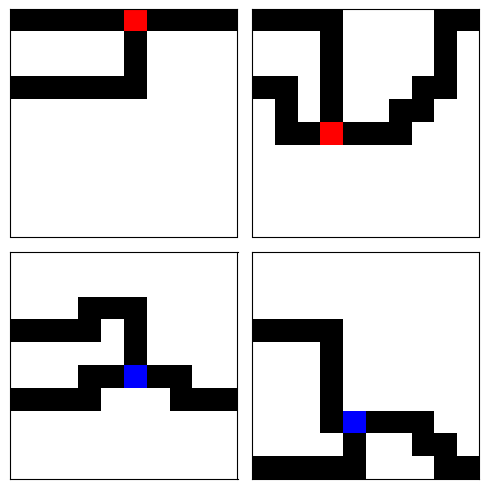

In [64]:
# Show dataset circuits

cmap = ListedColormap(['white', 'black', 'red', 'blue'])
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(argmaxedDataset[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [65]:
# Set truthtable embedder

class RowEmbedder(nn.Module):
    def __init__(self, num_categories, vector_length, embedding_dim):
        super().__init__()
        self.shared_embed = nn.Embedding(num_categories, embedding_dim)
        self.position_weights = nn.Parameter(torch.ones(vector_length, embedding_dim))
        self.position_bias = nn.Parameter(torch.zeros(vector_length, embedding_dim))
        
    def forward(self, x):
        # x shape: [batch_size, vector_length]
        shared = self.shared_embed(x)  # [batch_size, vector_length, emb_dim]
        # Apply position-specific scaling and shifting
        return shared * self.position_weights + self.position_bias
    

class TabularTransformer(nn.Module):
    def __init__(self, num_categories, num_features, d_model):
        super().__init__()
        self.d_model = d_model

        self.row_embedding = RowEmbedder(num_categories, num_features, d_model) #num_categories, vector_length, embedding_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model * num_features,
            nhead=8,
            dim_feedforward=2*d_model * num_features,
            batch_first=True,
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6,
        )
    
    def forward(self, x):
        #batch_size, num_rows, num_cols = x.shape

        rows = self.row_embedding(x) #bs, rows, columns, embedding
        #rows = rows.mean(dim=2)
        rows = rows.flatten(start_dim=2) 
        
    
        transformed = self.transformer(rows)

        return transformed

transformer = TabularTransformer(3, 12, 16)

print("embedder created as transformer")
print(f"Embedded shape: {transformer(InitialLabels)[0].shape}")

embedder created as transformer
Embedded shape: torch.Size([16, 192])


In [66]:
# Set up scheduler

class CategoricalScheduler:
    def __init__(self, TrainSteps = 200, numCategories = 4, betaStart = 0.0001, betaEnd = 0.02):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'
        self.numCategories = numCategories

        self.betas = torch.linspace(betaStart, betaEnd, TrainSteps, device=self.noiseDevice)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def addNoise(self, imageBatch, time):
        bs, ch, w, h = imageBatch.shape

        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # the per pixel probability distribution of the categories
            currentProbabilities = imageBatch

            # The chance of each state per pixel when noised            
            updatedProbabilities = currentProbabilities * alpha_t + (1 - alpha_t) / self.numCategories 
            updatedProbabilities = updatedProbabilities.permute(0, 2, 3, 1) # reshape such that it is flattened correctly below
            updatedProbabilities = updatedProbabilities.reshape(bs*w*h, self.numCategories)  
            

            # 1 Sample per value
            categoricalNoise = torch.multinomial(updatedProbabilities, 1, replacement=True)
            categoricalNoise = categoricalNoise.view(bs, w, h) # Shape: [bs, w, h]

            noisedImages = F.one_hot(categoricalNoise, num_classes=self.numCategories)
            noisedImages = noisedImages.permute(0, 3, 1, 2) # [bs, num_classes, w, h]

            return noisedImages

scheduler = CategoricalScheduler()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [67]:
# Create Diffuser

class CategoricalDiffusionModel(nn.Module):
    def __init__(self, imageSize, numCategories, embeddingSize, attentionHeads=8, guidanceProb=0.1):
        super().__init__()
        self.guidance_prob=guidanceProb
        self.model = UNet2DConditionModel(
            sample_size=imageSize, 
            in_channels=numCategories,  # Image channels
            out_channels=numCategories,
            cross_attention_dim=embeddingSize,  # Matches mbedding's token dim 
            attention_head_dim=attentionHeads,     # Smaller head dim for efficiency
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(128, 128, 128), 
            down_block_types=(
                "CrossAttnDownBlock2D",  
                "CrossAttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
        )
        
    def forward(self, x, t, embedding):
        bs, ch, w, h = x.shape

        #Use guidance probability, to help the model learn that 'circuit behvaior' 
        # is a general feature and not specific to a particular embedding.
        if self.training:
            mask = torch.rand_like(embedding, device=x.device) < self.guidance_prob
            embedding[mask] = 0

        return self.model(x, t, encoder_hidden_states=embedding).sample

loss = []
model = CategoricalDiffusionModel(10, 4, 192).to(device)

In [68]:
# Training Function

def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
    catModel.train()
    updateRate = 10 # For plotting purposes

    loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

    if PLOTUPDATES:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

    for epoch in range(epochs):
        
        for batch, labels in dataloader:

            timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

            noisyImgs = scheduler.addNoise(batch, timesteps)

            embeddings = embeddingModel(labels)

            pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))

            loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        if PLOTUPDATES:
            if epoch % updateRate == 0:
                clear_output(wait=True)  
                ax.clear()
                plt.plot(losses)
                plt.xlabel('Batch')
                display(fig)
    
    if PLOTUPDATES:
        clear_output(wait=True)  
        ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    if PLOTUPDATES:
        display(fig)

    return catModel, losses

In [69]:
# Create hashes of data to compare synthetic data with real data

# Function to get the hash of a tensor
def get_tensor_hash(tensor):
    # Flatten the tensor and convert to tuple (hashable)
    tensor_tuple = tuple(tensor.flatten().tolist())
    
    # Compute the hash using hashlib (SHA-256)
    hash_object = hashlib.sha256(str(tensor_tuple).encode())
    return hash_object.hexdigest()

dataset_hashes = {get_tensor_hash(tensor) for tensor in argmaxedDataset}
labels_hashes = {get_tensor_hash(tensor) for tensor in InitialLabels}

# This would be more efficient sorted

# print("Dataset Hashes:", dataset_hashes)
# print("Labels Hashes:", labels_hashes)
print("Dataset hash amount:", len(dataset_hashes))

Dataset hash amount: 4


In [70]:
# Sockets used for testing

inpSockets = [
    (Socket("inp0", True), (-1, 0)), 
    (Socket("inp1", True), (-1, 3)), 
    (Socket("inp2", True), (-1, 6)), 
    (Socket("inp3", True), (-1, 9)), 
]

outSockets = [  
    (Socket("out0", False), (10, 0)), 
    (Socket("out1", False), (10, 3)), 
    (Socket("out2", False), (10, 6)), 
    (Socket("out3", False), (10, 9)),
]

In [71]:
# Why pre and after pruning?
# Pruning unconnected wires won't make simulation faster, as they aren't even used in the connection or socket maps.
# So the idea was to only prune these things before adding them to the dataset.
# However, when checking if the generated circuit already exists, it helps also removing those wires
# So both pre and after pruning are used before simulating, yet the functions are kept separate, as is.


# Prunes inputs, outputs and wireSets that have only have components recieving or emitting signals.
# Wiresets with no components connected are never added to the connectionMap, so they are not pruned here, -
# These wiresets have no influence on the circuit's behavior (or simulation speed), -
# so pruning them can wait till after the circuit has been confirmed to be useful
def prePruning(connectionMap, socketMap):
    prunedConnections = []
    for connection in connectionMap:
        relevantConnection = any(
            component.isSource for component in connectionMap[connection]
        ) and any(
            not component.isSource for component in connectionMap[connection]
        )
        
        if not relevantConnection:
            prunedConnections.append(connection)

    for connection in prunedConnections:
        del connectionMap[connection]  

    connectedInputs = []
    connectedOutputs = []
    for socket, connections in socketMap.items():
        for connection in list(connections):
            if connection in prunedConnections:
                socketMap[socket].remove(connection)
                
        prefix, compid, comptype = socket.name
        
        if prefix == "inp" and bool(socketMap[socket]):
            connectedInputs.append(int(compid))
        elif prefix == "out" and bool(socketMap[socket]):
            connectedOutputs.append(int(compid))
    
    return connectedInputs, connectedOutputs


# Of the connected inputs, get combinations for a truthtable. for example socket [[], [0], [1], [0,1]]
def generateSocketCombinations(inputSockets, relevantIndexes):
    #inputSockets = All available input sockets
    #relevantIndexes = the indexes of sockets that are connected to components
    
    usedSockets = [inputSockets[i][0] for i in relevantIndexes]
    
    # Generate all combinations (power set)
    orderList = []
    for r in range(len(usedSockets) + 1):
        for combo in combinations(usedSockets, r):
            orderList.append(list(combo))
    
    return orderList

In [ ]:
# After pruning

# Things to prune:
# Unconncted wires
# wires from prepruning

def afterPruning(circuit, wiresets, connectionMap):
    # Prunes circuits, from pruned connections
    # And replaces gates that aren't connected on their emitter with wires.
    circuitWasUpdated = False

    for i in range(circuit.shape[0]):
        for j in range(circuit.shape[1]):
            if wiresets[i][j] not in connectionMap and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitWasUpdated = True
            elif circuit[i][j] > 1 and j < circuit.shape[1] - 1 and circuit[i][j + 1] == 0:
                circuit[i][j] = 1
                circuitWasUpdated = True

    #Because there gate positions aren't stored, socket map will have to be recreated, but then connetionmap will also need to be updated.
    return circuit, connectionMap, circuitWasUpdated

# Prunes excess wires from the circuit.
def pruneExcessWires(circuit):
    circuitDirty = False
    
    for j in range(1, circuit.shape[0] - 1):
        for i in range(circuit.shape[1]):
            center = circuit[i][j]
            up     = circuit[i - 1][j] if i > 0 else 0
            down   = circuit[i + 1][j] if i < circuit.shape[0] - 1 else 0
            left   = circuit[i][j - 1] 
            right  = circuit[i][j + 1] 

            crossValue = center + up + down + left + right

            if crossValue < 3 and circuit[i][j] == 1:
                circuit[i][j] = 0
                circuitDirty = True
    
    if circuitDirty:
        return pruneExcessWires(circuit)
    else: return circuit

def hasWireSquare(circuit):
    #Just disaallow these.
    rows = circuit.shape[0]
    cols = circuit.shape[1]

    for i in range(rows - 1):
        for j in range(cols - 1):
            if (circuit[i][j] == 1 and
                circuit[i][j + 1] == 1 and
                circuit[i + 1][j] == 1 and
                circuit[i + 1][j + 1] == 1):
                return True
    return False

In [73]:
def GetTruthTable(inputIndexes, outputIndexes, socketMap, connectionMap, orders):
    # Orders is a list of the order in which input sockets are activated.
    # # Truthtables usually do not make use of activation order, but the simulation needs it.

    truthTable = torch.ones(size=(2**len(inputIndexes), 12)) * 2

    row = 0
    #try
    for order in orders:
        for socket in socketMap.keys():
            socket.state = False
        
        # Gives the state of sockets at the end. But only output sockets are relevant, 
        # and those are available through outSockets[i][0]
        _ = Simulate(connectionMap, socketMap, order) 

        for index in inputIndexes:
            truthTable[row][index] = 0

        for socket in order:
            prefix, idnum, comptype = socket.name
            truthTable[row][int(idnum)] = 1

        for i in outputIndexes:
            truthTable[row][i + 8] = outSockets[i][0].state

        row += 1

    return truthTable

In [74]:
# Generate N Circuits
def GenerateN(model, amount = 100):
    model.eval()
    
    ## GENERATE CIRCUITS
    with torch.no_grad():
        batchX = torch.randint(size=(amount, 4, 10, 10), high = 1, low = 0, device=device )
        batchY = torch.randint(size=(amount, 4, 12), high = 2, low = 0, device='cpu' ) # WARNING! This is currently forced to shape (4, 12)
        batchY = transformer(batchY).to(device)
        
        # Inference with trainingsteps // 64 + 1, for faster generations. Even with this few steps, generations become perfect after training, due to small dataset.
        stepDivisor = 64
        inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // stepDivisor, device='cpu').long()

        for t in inferenceSteps:
            residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
            residual = F.softmax(residual_cond, dim=1)
            batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
        batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

        # Get circuit values
        argmaxedBatch = torch.argmax(batchX, dim=1, keepdim=True).cpu().numpy().squeeze()

        return argmaxedBatch

def getTables(circuits):
    #Prunes
    #Checks hashes
    #Simulates
    #Then, generates tables
    with torch.no_grad():
        tables = []
        simulatedCircuits = []
        simulatedCircuitHashes = []

        unique_hashes = {}
        for i in range((circuits.shape[0])):
            circuitDirty = True # Pruning flag

            while circuitDirty:
                socketMap, wireSets = GetSocketMap(circuits[i], inpSockets + outSockets)
                connectionMap = GetConnectionMap(socketMap)


                inps, outs = prePruning(connectionMap, socketMap)
                circuit, connectionMap, circuitDirty = afterPruning(circuits[i], wireSets, connectionMap)
                circuit = pruneExcessWires(circuit)

            hash = get_tensor_hash(circuit)
            if hash not in unique_hashes and hash not in dataset_hashes:
                unique_hashes[hash] = i

                #Get orderlist
                if len(inps) > 1 and len(outs) > 0: # Bias to have only circuits with at least 2 inputs
                    orderlist = generateSocketCombinations(inpSockets, inps)

                    try:    
                        truthTable = GetTruthTable(inps, outs, socketMap, connectionMap, orderlist)
                        tables.append(truthTable)
                        simulatedCircuits.append(circuit)
                        simulatedCircuitHashes.append(hash)

                    except Exception as e:
                        print(f"Error in circuit {i}: {e}")
                
        return tables, simulatedCircuits, simulatedCircuitHashes

In [75]:
# The 3 above functions concattenated 

def GenerateAndSimulate(model, lossList, amount = 100, plotResults = True):
    argmaxCircuits = GenerateN(model, amount)

    tables, simulatedCircuits, simulatedCircuitsHashes = getTables(argmaxCircuits)
    print(f"Generated {len(tables)} truth tables. {len(argmaxCircuits) - len(tables)} circuits weren't used")

    if plotResults:
        # plot the top 25 circuits.
        cmap = ListedColormap(['white', 'black', 'red', 'blue'])
        cols = 5
        rows = min(len(simulatedCircuits) + 4, 25) // cols
        if rows == 0:
            return tables, simulatedCircuits

        fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))

        for idx, ax in enumerate(axes.flat):
            ax.set_xticks([])
            ax.set_yticks([])
            if idx >= len(simulatedCircuits):
                continue
            ax.imshow(simulatedCircuits[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)

        fig.suptitle(f"Epoch {len(lossList)}")
        plt.tight_layout()
        plt.show()

    return tables, simulatedCircuits, simulatedCircuitsHashes

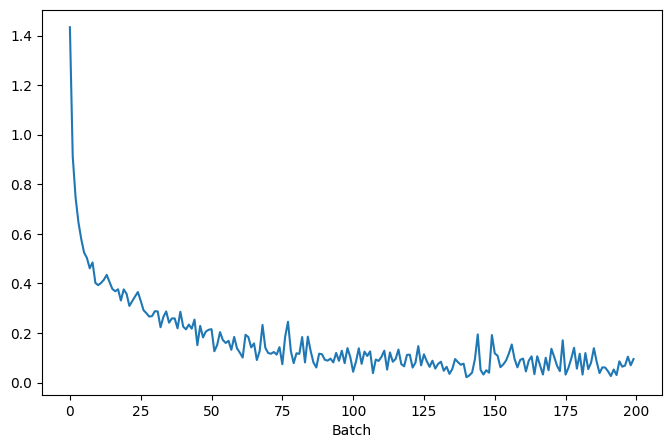

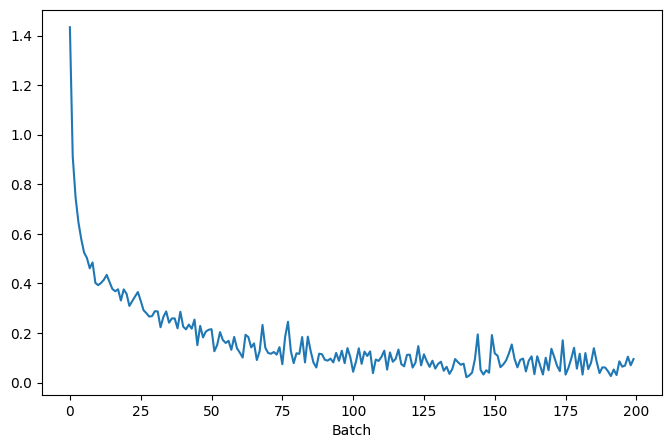

In [76]:
model = CategoricalDiffusionModel(10, 4, 192).to(device)
loss = []
model, loss = trainCatModel(model, loader, 200, transformer, loss)

In [77]:
newCircuits = []
newCircuitHashes = []
newTables = []

In [78]:
for i in range(10):
    t, a, h = GenerateAndSimulate(model, loss, amount=500, plotResults=False)
    for circuit, hash, table in zip(a, h, t):
        if hash not in newCircuitHashes:
            newCircuitHashes.append(hash)   
            newCircuits.append(circuit)
            newTables.append(table)
len(newCircuits)

Generated 5 truth tables. 495 circuits weren't used
Generated 5 truth tables. 495 circuits weren't used
Generated 5 truth tables. 495 circuits weren't used
Generated 2 truth tables. 498 circuits weren't used
Generated 1 truth tables. 499 circuits weren't used
Generated 6 truth tables. 494 circuits weren't used
Generated 6 truth tables. 494 circuits weren't used
Generated 5 truth tables. 495 circuits weren't used
Generated 2 truth tables. 498 circuits weren't used
Generated 0 truth tables. 500 circuits weren't used


20

In [79]:
argmaxedDataset = torch.cat((argmaxedDataset, torch.tensor(newCircuits)), dim=0)
syntheticLabels = torch.stack([tablePadding(torch.tensor(t)) for t in newTables])
syntheticLabels = torch.cat((InitialLabels, syntheticLabels), dim=0).long()

syntheticData = imageToProbabilities(argmaxedDataset, 4)

newDataset = TensorDataset(syntheticData, syntheticLabels)
loader = DataLoader(newDataset, batch_size=64, shuffle=True)

C:\Users\hellf\AppData\Local\Temp\ipykernel_20888\2569284731.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  syntheticLabels = torch.stack([tablePadding(torch.tensor(t)) for t in newTables])


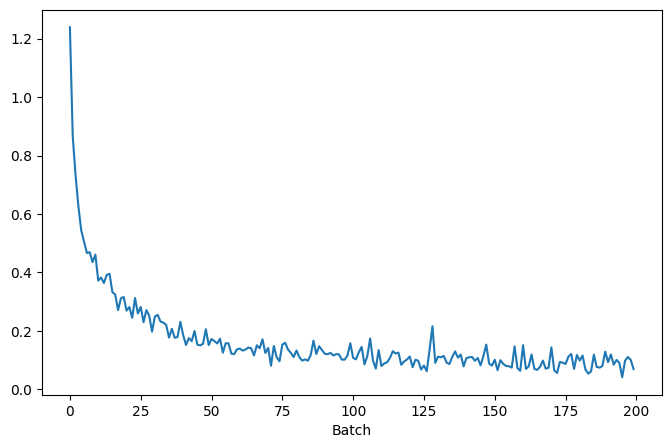

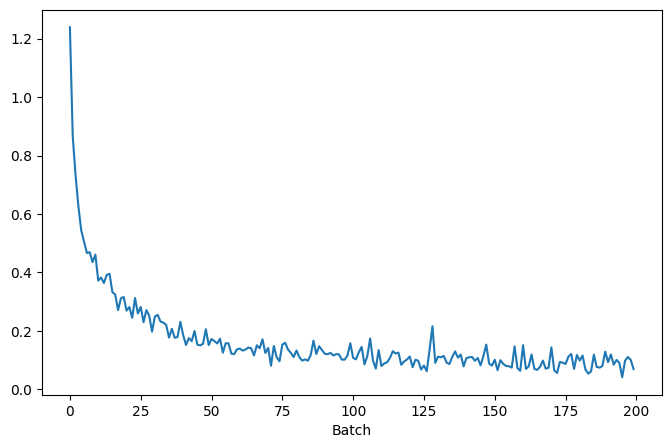

In [80]:
model = CategoricalDiffusionModel(10, 4, 192).to(device)
loss = []
model, loss = trainCatModel(model, loader, 200, transformer, loss)

Generated 42 truth tables. 458 circuits weren't used


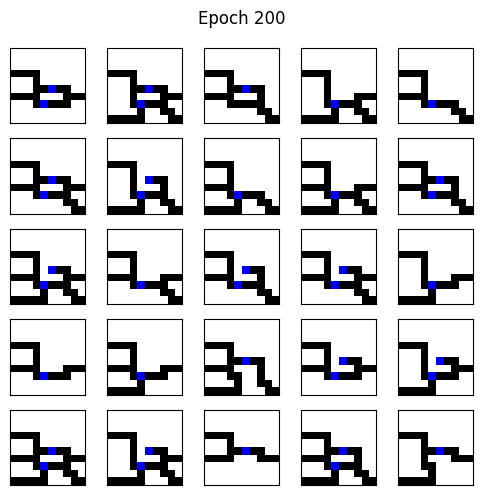

In [81]:
t, a, h = GenerateAndSimulate(model, loss, amount=500, plotResults=True)

Problems:
1. Error is weridly low -> fixed
2. It is training for doubled the epochs for some reason -> it isn't, graph shows batch num.
3. Circuits are unusable

test:
1. Remove all circuits where there is a 2x2 square of wires
2. Remove entire circuits if they have excess wire. To check this, use convolution-ish

```
?x?
xxx
?x?
```
and sum of x's must be above 2 for center x. This will need to check edges.

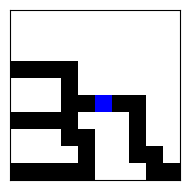

In [104]:
testIndex = 23
#argmaxedDataset

printCircuit(argmaxedDataset[testIndex])
#print(argmaxedDataset[testIndex])

In [24]:
with torch.no_grad():
    pruneExcessWires(argmaxedDataset[testIndex])
printCircuit(argmaxedDataset[testIndex])

KeyboardInterrupt: 